## Display Data

https://www.kaggle.com/code/ahmedali30/plasticanamolydetection-svm/notebook

In [47]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

def show_random_images(train_folder, test_folder, num_images=8):
    """Displays a grid of random images from the training and test folders with labels."""

    # Get a list of image paths from both folders
    train_images = [os.path.join(train_folder, img) for img in os.listdir(train_folder)]
    test_images = [os.path.join(test_folder, subfolder, img) for subfolder in os.listdir(test_folder) for img in os.listdir(os.path.join(test_folder, subfolder))]

    # Combine the image paths and labels
    all_images = train_images + test_images
    all_labels = ['Train'] * len(train_images) + ['Test'] * len(test_images)

    # Randomly sample images and labels
    samples = list(zip(all_images, all_labels))
    random.shuffle(samples)
    images, labels = zip(*samples[:num_images])

    # Create a grid of subplots
    num_rows = 2
    num_cols = num_images // 2
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6))

    # Display the images with labels
    for i, (image_path, label) in enumerate(zip(images, labels)):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        ax = axes.flat[i]
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
data_folder = '/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/data/'
object_name = 'screw'
train_folder = os.path.join(data_folder, object_name, 'train', 'good')
test_folder = os.path.join(data_folder, object_name, 'test')

show_random_images(train_folder, test_folder, num_images=8)

KeyboardInterrupt: 

## Examine Data

https://www.kaggle.com/code/ahmedali30/plasticanamolydetection-svm/notebook

Image shape: (150528,)


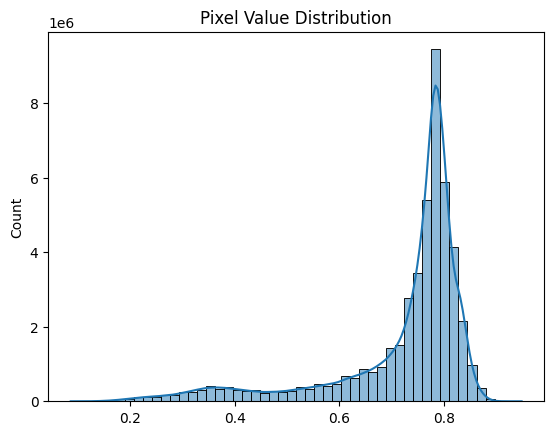

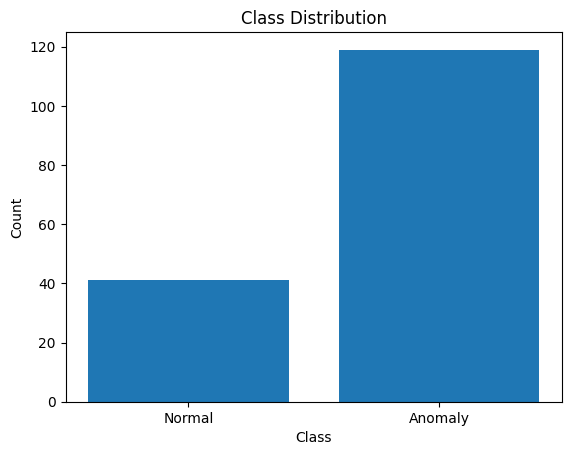

In [4]:
def load_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Error loading image: {img_path}")
                continue
            img = cv2.resize(img, (224, 224))
            img = img / 255.0
            images.append(img.flatten())
        except Exception as e:
            print(f"Error processing image: {img_path}, Error: {e}")
    return np.array(images)

def load_test_data(test_folder_path):
    X_test = []
    y_test = []
    for subfolder in os.listdir(test_folder_path):
        subfolder_path = os.path.join(test_folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Error loading image: {img_path}")
                    continue
                img = cv2.resize(img, (224, 224))
                img = img / 255.0
                X_test.append(img.flatten())
                if subfolder == 'good':
                    y_test.append(0)  # Normal
                else:
                    y_test.append(1)  # Anomaly
            except Exception as e:
                print(f"Error processing image: {img_path}, Error: {e}")
    return np.array(X_test), np.array(y_test)

def analyze_data_distribution(train_images, y_test):
    # Image shape analysis
    image_shape = train_images[0].shape
    print(f"Image shape: {image_shape}")

    # Pixel value distribution
    flattened_images = train_images.reshape(-1)
    sns.histplot(flattened_images, bins=50, kde=True)
    plt.title('Pixel Value Distribution')
    plt.show()

    # Class distribution
    class_counts = np.bincount(y_test)
    plt.bar(range(len(class_counts)), class_counts)
    plt.xticks(range(len(class_counts)), ['Normal', 'Anomaly'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()
    
data_folder = '/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/data/'
object_name = 'screw'

train_folder = os.path.join(data_folder, object_name, 'train', 'good')
test_folder = os.path.join(data_folder, object_name, 'test')

train_images = load_images(train_folder)
X_test, y_test = load_test_data(test_folder)

# Analyze data distribution
analyze_data_distribution(train_images, y_test)

## Show Defects

https://www.kaggle.com/code/stpeteishii/toothbrush-anomalies-autoencoder

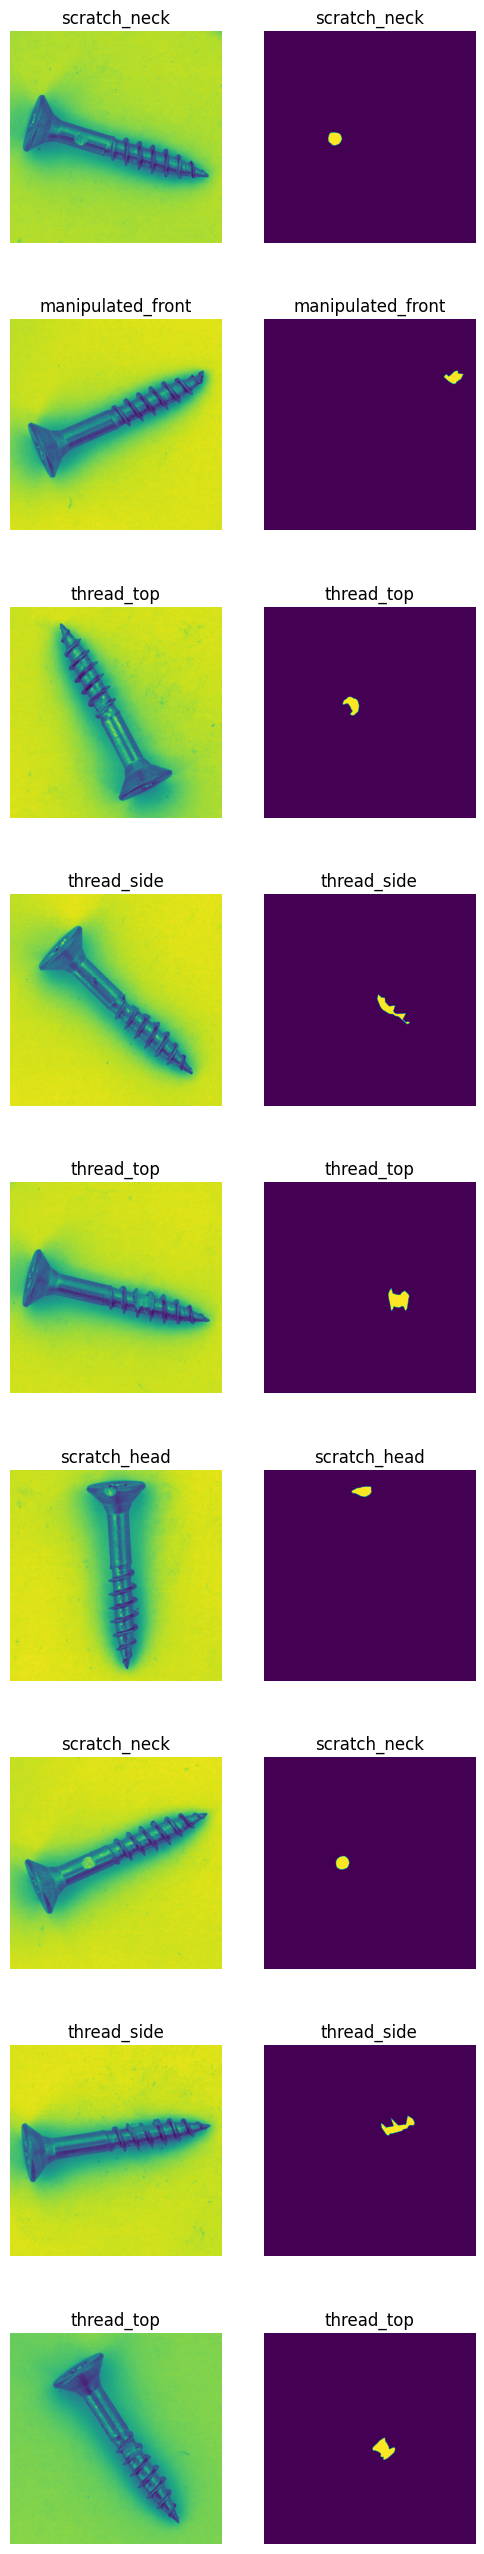

In [5]:
paths=[]
data_folder = '/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/data/'
object_name = 'screw'

for dirname, _, filenames in os.walk('/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/data/screw/test'):
    for filename in filenames:
        if dirname.split('/')[-1]!='good':
            paths+=[(os.path.join(dirname, filename))]
paths=random.sample(paths,9)

dir0='/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/data/screw/ground_truth'

fig, axs = plt.subplots(9,2,figsize=(6,33))
for i in range(9):
    r=i

    path=paths[i]
    img = plt.imread(path)
    label=path.split('/')[-2]
    ax=axs[r][0].axis("off")
    ax=axs[r][0].set_title(label)
    ax=axs[r][0].imshow(img)

    path=paths[i]
    file=path.split('/')[-1].split('.')[0]+'_mask.png'
    label=path.split('/')[-2]    
    path2=os.path.join(dir0,label,file)
    img = plt.imread(path2)
    ax=axs[r][1].axis("off")
    ax=axs[r][1].set_title(label)
    ax=axs[r][1].imshow(img)
    
plt.show()

## Vanilla Autoencoder

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Set up device configuration for M1 GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

################################
###### Load Data

# Image preprocessing and augmentation
data_dir = '/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/data/screw'
train_dir = f'{data_dir}/train'
test_dir = f'{data_dir}/test'

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=16,
    class_mode='input',
    color_mode='rgb',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=16,
    class_mode='input',
    color_mode='rgb',
    subset='validation'
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(512, 512),
    batch_size=16,
    class_mode='input',
    color_mode='rgb',
    shuffle=False
)

################################
###### Create Model
def build_autoencoder(input_shape=(512, 512, 3)):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    encoded = Conv2D(512, (3, 3), padding='same')(x)
    encoded = BatchNormalization()(encoded)
    encoded = LeakyReLU()(encoded)

    # Decoder
    x = UpSampling2D((2, 2))(encoded)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Output layer with sigmoid activation for pixel values in [0, 1]
    decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Build and summarize the model
autoencoder = build_autoencoder()
autoencoder.summary()


################################
###### Train Autoencoder

# Train the autoencoder
history = autoencoder.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Optional: Save model
# autoencoder.save('autoencoder_model.h5')


Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 160 images belonging to 6 classes.


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 512, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512, 512, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 512, 512, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 64, 64, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,142,531 (11.99 MB)

 Trainable params: 3,139,587 (11.98 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/50
 5/16 ━━━━━━━━━━━━━━━━━━━━ 2:11 12s/step - loss: 0.0843

KeyboardInterrupt: 

## Plot Reconstructions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


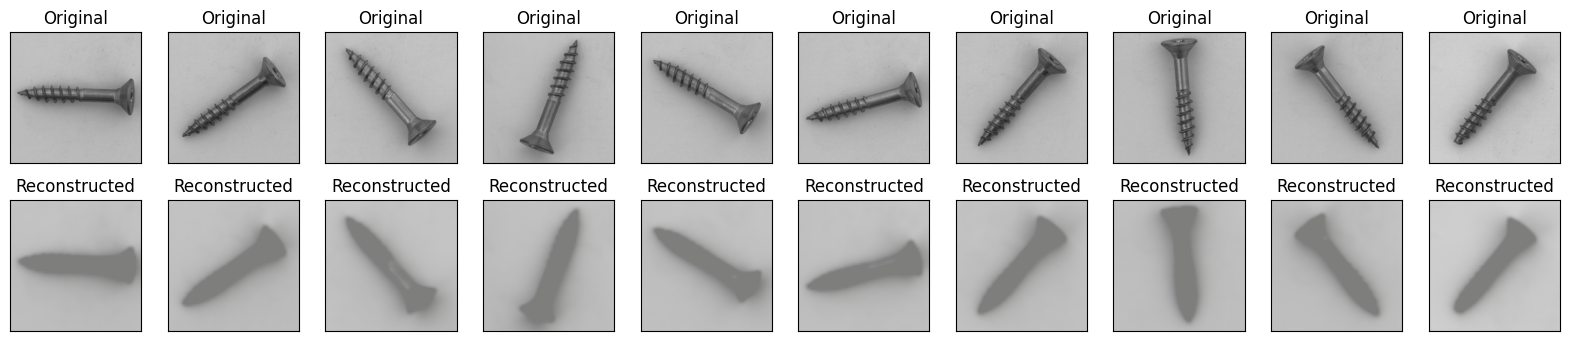

In [40]:
# Fetch a batch of images
original_images, _ = next(test_generator)  # Ignore labels since class_mode='input'

# Generate reconstructions
reconstructed_images = autoencoder.predict(original_images)

# Ensure the images are in float32 and within the range [0, 1]
original_images = original_images.astype('float32')
reconstructed_images = np.clip(reconstructed_images.astype('float32'), 0, 1)

def plot_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plot_images(original_images, reconstructed_images, n=10)

## Evaluate the Autoencoder

In [41]:

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

test_dir = '/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/data/screw/test'

# Configure ImageDataGenerator to automatically generate labels based on subfolder structure
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical',  # Use 'categorical' if you have multiple anomaly types
    shuffle=False  # To maintain order
)

# Print the total number of images in the test set
print(f"Total number of images in test set: {test_generator.samples}")

# Calculate the number of batches
num_batches = int(np.ceil(test_generator.samples / test_generator.batch_size))
print(f"Number of Batches: {num_batches}")

# 1. Calculate reconstruction errors for the test set
def calculate_reconstruction_errors(autoencoder, test_generator, num_batches):
    errors = []
    labels = []  # Store the true labels for evaluation
    
    for i, (batch, batch_labels) in enumerate(test_generator):
        if i >= num_batches:  # Stop after one pass through the dataset
            break

        print(f"Reconstructing image batch No {i+1} out of {num_batches}")

        # Generate reconstructions
        reconstructed_batch = autoencoder.predict(batch)
        
        # Calculate reconstruction error for each image in the batch
        batch_errors = np.mean(np.square(batch - reconstructed_batch), axis=(1, 2, 3))
        
        errors.extend(batch_errors)
        labels.extend(batch_labels)  # Store true labels (0 for normal, 1 for anomaly)
        
    return np.array(errors), np.array(labels)

# 2. Calculate reconstruction errors and determine an appropriate threshold
reconstruction_errors, true_labels = calculate_reconstruction_errors(autoencoder, test_generator, num_batches)
threshold = np.percentile(reconstruction_errors, 95)

true_labels = np.where((true_labels == [1, 0, 0, 0, 0, 0]).all(axis=1), 0, 1)

# 3. Classify test images based on the threshold
predicted_labels = (reconstruction_errors > threshold).astype(int)
print(predicted_labels)
print(true_labels)

# 4. Evaluate the results
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Threshold:", threshold)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Found 160 images belonging to 6 classes.
Total number of images in test set: 160
Number of Batches: 5
Reconstructing image batch No 1 out of 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
Reconstructing image batch No 2 out of 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
Reconstructing image batch No 3 out of 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Reconstructing image batch No 4 out of 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
Reconstructing image batch No 5 out of 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1

## Detect anomalies with the AE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


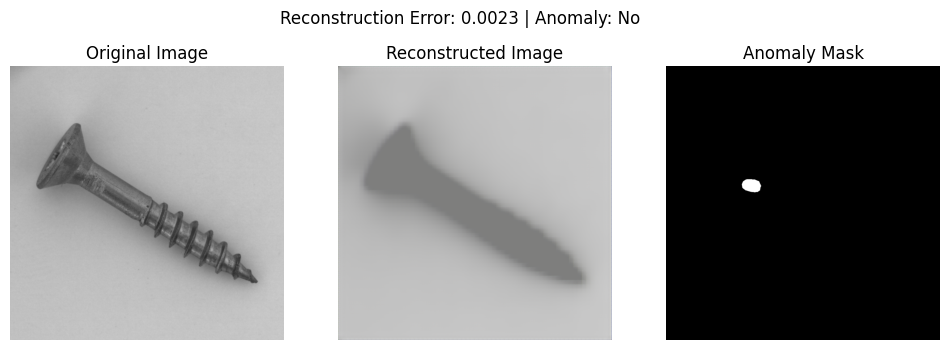

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


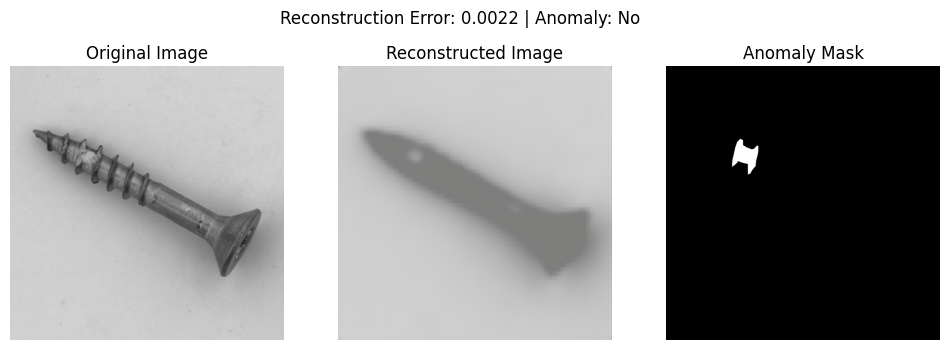

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


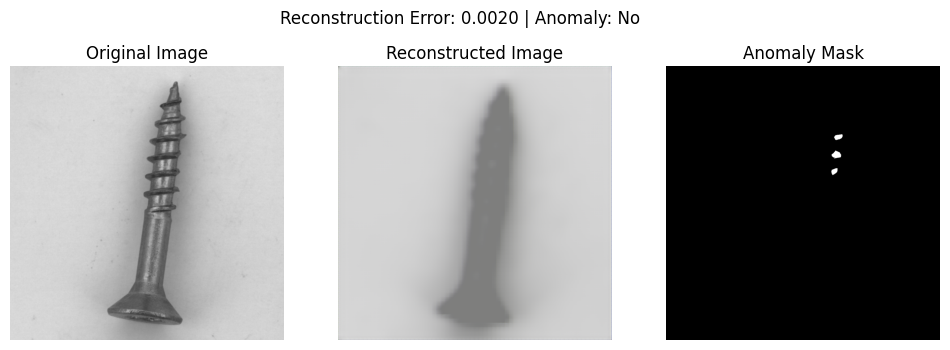

In [43]:
import os
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size=(512, 512)):
    """Load and preprocess an image for the autoencoder."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0  # Normalize to [0, 1] and set to float32
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def calculate_reconstruction_error(original, reconstructed):
    """Calculate the mean squared error between original and reconstructed images."""
    return np.mean((original - reconstructed) ** 2)

def predict_anomaly_and_plot(autoencoder, image_path, mask_dir, threshold=0.02):
    """
    Predict if an image is an anomaly based on reconstruction error
    and plot original, reconstructed, and mask images.
    
    Parameters:
        autoencoder (Model): The trained autoencoder model.
        image_path (str): Path to the image file.
        mask_dir (str): Directory containing anomaly mask images.
        threshold (float): Error threshold to classify as anomaly.
    
    Returns:
        bool: True if anomaly, False otherwise.
        float: The reconstruction error.
    """
    # Preprocess the image
    img = preprocess_image(image_path)
    
    # Reconstruct the image with the autoencoder
    reconstructed_img = autoencoder.predict(img)

    # Ensure reconstructed image is in float32 format
    reconstructed_img = reconstructed_img.astype('float32')
    
    # Calculate reconstruction error
    error = calculate_reconstruction_error(img, reconstructed_img)
    
    # Classify as anomaly if error exceeds the threshold
    is_anomaly = error > threshold

    # Generate the corresponding mask path
    file_name = os.path.basename(image_path).split('.')[0] + '_mask.png'
    label = os.path.basename(os.path.dirname(image_path))
    mask_path = os.path.join(mask_dir, label, file_name)
    
    # Load the mask image if it exists
    if os.path.exists(mask_path):
        mask_img = plt.imread(mask_path)
    else:
        mask_img = None

    # Plot original, reconstructed, and mask images
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img[0])  # Remove batch dimension for display
    plt.title("Original Image")
    plt.axis("off")
    
    # Reconstructed image
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_img[0])  # Remove batch dimension for display
    plt.title("Reconstructed Image")
    plt.axis("off")
    
    # Anomaly mask
    plt.subplot(1, 3, 3)
    if mask_img is not None:
        plt.imshow(mask_img, cmap="gray")
        plt.title("Anomaly Mask")
    else:
        plt.text(0.5, 0.5, 'No Mask Available', ha='center', va='center', fontsize=12)
    plt.axis("off")
    
    plt.suptitle(f"Reconstruction Error: {error:.4f} | Anomaly: {'Yes' if is_anomaly else 'No'}")
    plt.show()
    
    return is_anomaly, error

# Example usage
mask_dir = '/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/data/screw/ground_truth'
image_paths = [
    '/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/data/screw/test/scratch_neck/000.png',
    '/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/data/screw/test/thread_top/000.png', 
    '/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/data/screw/test/thread_side/000.png' 
]

for path in image_paths: 
    is_anomaly, error = predict_anomaly_and_plot(autoencoder, path, mask_dir, threshold=0.02)
